### Package Imports

In [12]:
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle as pkl
from operator import itemgetter
import os
import random
from skimage import io
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, confusion_matrix, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ZeroPadding2D, AveragePooling2D, GaussianNoise, SeparableConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import time
from tqdm import tqdm, tqdm_notebook
from functools import partial
from PIL import ImageStat, Image
import os
import logging
from google.cloud import storage
import cv2
from io import BytesIO

### Config

In [13]:
# Directory paths
config_bucket_name = "indoor_scenes"
config_prefix_name = "agg_scene_dir_proc_iii"

# Processing config
config_test_percent = 0.10
config_validation_perc = 0.2
config_img_height = 220
config_img_width = 220
config_color_mode = "rgb"
config_check_for_duplicates = False
config_n_classes = 5
config_random_state = 2019
config_sample_perc = None


# Model save & callback config
config_model_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
config_model_save_name = "cloud_scene_img_model_sgd_lrs_{dt_tm}.hdf5".format(dt_tm = config_model_timestamp)
config_max_worse_epochs = 25


# Model training config
config_batch_size = 30
config_warmup_epochs = 5
config_cooldown_epochs = 5
config_cycle_length = 10
config_sgd_lr = 0.0003
config_min_lr = 0.00001
config_max_lr = 0.00015
config_epochs = 400
config_cnn_activation = 'relu'
config_dense_dropout = 0.1
config_conv_dropout = 0.0
config_l2_reg = 0.00001

### Define Functions

In [14]:
def seconds_to_time(sec):
    """convert seconds (integer or float) to time in 'hh:mm:ss' format"""
    if (sec // 3600) == 0:
        HH = '00'
    elif (sec // 3600) < 10:
        HH = '0' + str(int(sec // 3600))
    else:
        HH = str(int(sec // 3600))
    min_raw = (np.float64(sec) - (np.float64(sec // 3600) * 3600)) // 60
    if min_raw < 10:
        MM = '0' + str(int(min_raw))
    else:
        MM = str(int(min_raw))
    sec_raw = (sec - (np.float64(sec // 60) * 60))
    if sec_raw < 10:
        SS = '0' + str(int(sec_raw))
    else:
        SS = str(int(sec_raw))
    return HH + ':' + MM + ':' + SS + ' (hh:mm:ss)'

def sec_to_time_elapsed(end_tm, start_tm, return_time = False):
    """apply seconds_to_time function to start and end times
       * dependency on seconds_to_time() function *"""
    sec_elapsed = (np.float64(end_tm) - np.float64(start_tm))
    if return_time:
        return seconds_to_time(sec_elapsed)
    else:
        print('Execution Time: ' + seconds_to_time(sec_elapsed))
        
def make_class_weight_dict(train_y_labels, return_dict = False):
    """
    Return dictionary of inverse class weights for imbalanced response
    Args:
        train_y_labels: training set response variable (list or numpy array)
        return_dict: if True, return dictionary of classes & weights..else return list of classes and list of weights
    """
    
    if str(type(train_y_labels)) == "<class 'numpy.ndarray'>":
        labs = list(range(train_y_labels.shape[1]))
        freq = list(np.sum(train_y_labels, axis = 0))
        train_class_counts = dict(zip(labs, freq))
    else:
        train_class_counts = dict((x,train_y_labels.count(x)) for x in set(train_y_labels))
    max_class = max(train_class_counts.values())
    class_weights = [max_class / x for x in train_class_counts.values()]
    class_weight_dict = dict(zip([i for i in train_class_counts.keys()], class_weights))
    if return_dict:
        return class_weight_dict
    else:
        return list(class_weight_dict.keys()), list(class_weight_dict.values())
 
    
def load_resize_images(full_file_paths, resize_height, resize_width):
    """
    Load images and resize according to function arguments
    Args:
        full_file_paths: list of saved image files
        resize_height: height of resized output images
        resize_width: width of resized output images
    Depdendencies:
        numpy
        skimage.transform.resize
        tensorflow.keras.preprocessing.image.load_img
    Returns:
        numpy array of resized images
    """
    read_images = [load_img(c) for c in full_file_paths]
    resized_images = [resize(np.array(ri), (resize_height, resize_width)) for ri in read_images]
    return np.array(resized_images)



def img_add_flip(arr, flip_horiz = True, flip_vert = False):
    """
    Flip numpy array horizontally and/or vertically
    Args:
        arr: three dimensional numpy array
        flip_horiz: flip image horizontally
        flip_vert: flip image vertically
    """
    assert len(arr.shape) == 3, "'arr' input array must be three dimensional"
    arr_copy = arr.copy()
    if flip_horiz:
        arr_copy = np.fliplr(arr_copy)
    if flip_vert:
        arr_copy = np.flipud(arr_copy)
    return arr_copy


def distort_oversamp_img(arr):
    """
    Apply distortions to oversampled image array
    """
    temp = img_add_flip(arr, flip_horiz = True, flip_vert = False)
    h_croplow = int(random.sample(list(range(30, int(temp.shape[0]/2))),1)[0])
    h_crophigh = h_croplow + 30
    v_croplow = int(random.sample(list(range(30, int(temp.shape[1]/2))),1)[0])
    v_crophigh = v_croplow + 30
    temp[h_croplow:h_crophigh,] = np.random.normal(0.5, 0.2, (30,temp.shape[1],3))
    temp[:,v_croplow:v_crophigh] = np.random.normal(0.5, 0.2, (temp.shape[0],30,3))
    gaussian = np.random.normal(0.1, 0.05, (temp.shape[0],temp.shape[1],temp.shape[2])) 
    temp = temp + gaussian
    return temp



def rebalance_classes(x_arr, y_arr):
    """
    Rebalance image classes using oversampling and horizontal flips to reduce redundancy
    Args:
        x_arr: 4d numpy array of images
        y_arr: 1d array of class labels
    Returns:
        x and y arrays with oversampled images appended
    """
    class_lst, class_wt = make_class_weight_dict(list(y_arr), return_dict = False)
    over_x = []
    over_y = []
    for i, x in enumerate(class_wt):
        if x > 1:
            class_positions = [j for j, y in enumerate(y_arr) if y == class_lst[i]]
            n_oversamp = int((x - 1) * len(class_positions))
            oversamp_positions = random.sample(class_positions, n_oversamp)
            over_y.append(y_arr[oversamp_positions])
            over_x.append([distort_oversamp_img(xa) for xa in x_arr[oversamp_positions]])
    out_x = np.vstack([x_arr, np.vstack(over_x)])
    out_y = np.concatenate([y_arr, np.concatenate(over_y)])
    return out_x, out_y


def np_array_to_batch_gen(x_arr, y_arr, batch_size = config_batch_size):
    """
    Create Keras generator objects for minibatch training
    Args:
        x_arr: array of predictors
        y_arr: array of targets
        batch_size: size of minibatches
    """
    indices = np.arange(len(x_arr)) 
    batch_list = []
    while True:
            np.random.shuffle(indices) 
            for i in indices:
                batch_list.append(i)
                if len(batch_list)==batch_size:
                    yield x_arr[batch_list], y_arr[batch_list]
                    batch_list=[]


def rand_coords_missing(arr, n_chunks = 10, chunk_size = 20):
    """
    Fill random square chunks of picture with noise based on the batch mean and standard deviation
    """    
    arr_copy = arr.copy()
    for i in range(n_chunks):
        pt_a = random.sample(range(chunk_size, arr.shape[0]), 1)[0]
        pt_b = pt_a + chunk_size
        pt_c = random.sample(range(chunk_size, arr.shape[1]), 1)[0]
        pt_d = pt_c + chunk_size
        arr_copy[pt_a:pt_b, pt_c:pt_d] = np.mean(arr_copy)
    return arr_copy


def rand_crop_arr(arr, perc_pixels = 0.15) :
    """
    Crop the left or right <perc_pixels> from a 3d numpy array
    > left or right is chosen randomly
    """
    arr_copy = arr.copy()
    side_choice = random.choice([0,1,2,3])
    if side_choice == 0:
        crop_coord = arr_copy.shape[0] - int(arr_copy.shape[0] * perc_pixels)
        arr_copy[crop_coord:,:] = np.mean(arr_copy)
    elif side_choice == 1:
        crop_coord = 0 + int(arr_copy.shape[0] * perc_pixels)
        arr_copy[:crop_coord,:] = np.mean(arr_copy)
    elif side_choice == 2:
        crop_coord = arr_copy.shape[1] - int(arr_copy.shape[1] * perc_pixels)
        arr_copy[:,crop_coord:,] = np.mean(arr_copy)
    else:
        crop_coord = 0 + int(arr_copy.shape[1] * perc_pixels)
        arr_copy[:,:crop_coord,] = np.mean(arr_copy)
    return arr_copy


def random_coords_zoom(arr, zoom_perc = 0.7):
    """
    Zoom in on <zoom_perc> of numpy 3d array image
    """
    chunk_size = int(arr.shape[0] * zoom_perc)
    arr_copy = arr.copy()
    pt_a = random.sample(range(0, arr.shape[0] - chunk_size - 1), 1)[0]
    pt_b = pt_a + chunk_size
    pt_c = random.sample(range(0, arr.shape[1] - chunk_size), 1)[0]
    pt_d = pt_c + chunk_size
    return resize(arr_copy[pt_a:pt_b, pt_c:pt_d], (arr_copy.shape[0], arr_copy.shape[0]))


def color_distort_arr(arr):
    """
    Distort rgb ratio of numpy array
    """
    arr_copy = arr.copy()
    color_to_distort = random.choice([0,1,2])
    arr_copy[:,:,color_to_distort] *= np.random.normal(1,.15,1)[0]
    return arr_copy


def rotate_arr(img, max_angle = 20, min_angle = -20, bg_patch=(5,5)):
    """
    Rotate image and use mean color for edges
    """
    from scipy.ndimage import rotate
    use_angle = random.choice(list(range(min_angle, max_angle)))
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, use_angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

                   
def np_array_to_batch_gen_aug(x_arr, y_arr, batch_size = config_batch_size):
    """
    Create Keras generator objects for minibatch training
        > apply mild color distortion and rotation to every image
        > every second array is flipped horizontally
        > every fifth array has 10 random 20 x 20 chunks filled with mean color
        > every ninth array has 70% zoom applied on random coordinates
        > every seventh array has a 15% crop of the left, right, bottom or top
        > every eleventh array is flipped vertically
    Args:
        x_arr: array of predictors
        y_arr: array of targets
        batch_size: size of minibatches
    """
    indices = np.arange(len(x_arr)) 
    batch_list = []
    while True:
            np.random.shuffle(indices) 
            for i in indices:
                batch_list.append(i)
                if len(batch_list)==batch_size:
                    x_arr_aug = np.array([color_distort_arr(x) for x in x_arr[batch_list]])
                    x_arr_aug = np.array([np.fliplr(x) if (j//2) == (j/2) else x for j, x in enumerate(x_arr_aug)])
                    x_arr_aug = np.array([rand_coords_missing(x) if (j//5) == (j/5) else x for j, x in enumerate(x_arr_aug)])
                    x_arr_aug = np.array([rand_crop_arr(x) if (j//7) == (j/7) else x for j, x in enumerate(x_arr_aug)])
                    x_arr_aug = np.array([np.flipud(x) if (j//11) == (j/11) else x for j, x in enumerate(x_arr_aug)])
                    x_arr_aug = np.array([random_coords_zoom(x) if (j//9) == (j/9) else x for j, x in enumerate(x_arr_aug)])
                    yield x_arr_aug, y_arr[batch_list]
                    batch_list=[]
                                  
                    
def augment_batch_gen(img_gen, augment_gen):
    """
    Apply Keras ImageDataGenerator to batch generation function
    Args:
        img_gen: batch generator object
        augment_gen: Keras ImageDataGenerator object
    """
    for Xi, Yi in img_gen:
        Xaug = augment_gen.flow(Xi * 255, Yi, batch_size = Xi.shape[0])
        Xo, Yo = next(Xaug)
        yield Xo/255.0, Yo
        

def triple_conv2d(input_x, filter_size, kernel_size, l2_reg, activation, use_batchnorm = True, use_maxpool = True):
    # Layer 1
    x = Conv2D(filters = filter_size, kernel_size = kernel_size,
               kernel_regularizer = l2(l2_reg), strides = (2,2), padding = "same")(input_x)
    x = Activation(activation)(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    
    # Layer 2
    x = Conv2D(filters = filter_size, kernel_size = kernel_size,
               kernel_regularizer = l2(l2_reg), strides = (1,1), padding = "same")(x)
    x = Activation(activation)(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    
    # Layer 3
    x = Conv2D(filters = filter_size, kernel_size = kernel_size,
               kernel_regularizer = l2(l2_reg), strides = (1,1), padding = "same")(x)
    x = Activation(activation)(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    if use_maxpool:
        x = MaxPooling2D(pool_size = (2,2))(x)
    return x


def conv_10_layer(dense_dropout = config_dense_dropout, conv_dropout = config_conv_dropout,
                  l2_reg = config_l2_reg, kernel_size = (3,3), img_height = config_img_height,
                  img_width = config_img_width, color_mode = config_color_mode, activ = config_cnn_activation,
                  n_classes = config_n_classes):
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)
    
    # Initial convolutional layer
    x = Conv2D(filters = 64, kernel_size = (8,8), padding = "same")(x_input)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    
    # Triple convolutional layers
    x = triple_conv2d(x, filter_size = 64, kernel_size = (3,3), l2_reg = l2_reg, activation = activ, use_maxpool = False)
    x = triple_conv2d(x, filter_size = 128, kernel_size = (3,3), l2_reg = l2_reg, activation = activ, use_maxpool = False)
    x = triple_conv2d(x, filter_size = 256, kernel_size = (3,3), l2_reg = l2_reg, activation = activ, use_maxpool = False)
                                          
    # Dense Layers
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation(activ)(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(64)(x)
    x = Activation(activ)(x)
    x = Dense(n_classes, activation = "softmax")(x)
    
    # Model object
    model = Model(inputs = x_input, outputs = x, name = 'conv_10_layer') 
    return model                                                
        
                                                                                                                      
def conv_12_layer(dense_dropout = config_dense_dropout, conv_dropout = config_conv_dropout,
                  l2_reg = config_l2_reg, kernel_size = (3,3), img_height = config_img_height,
                  img_width = config_img_width, color_mode = config_color_mode, activ = config_cnn_activation,
                  n_classes = config_n_classes):
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)
    
    # Initial convolutional layer
    x = Conv2D(filters = 64, kernel_size = (8,8), padding = "same")(x_input)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    
    # Triple convolutional layers
    x = triple_conv2d(x, filter_size = 64, kernel_size = (3,3), l2_reg = l2_reg, activation = activ)
    x = triple_conv2d(x, filter_size = 128, kernel_size = (3,3), l2_reg = l2_reg, activation = activ)
    x = triple_conv2d(x, filter_size = 256, kernel_size = (3,3), l2_reg = l2_reg, activation = activ)
    x = triple_conv2d(x, filter_size = 512, kernel_size = (3,3), l2_reg = l2_reg, activation = activ)
    
    # Dense Layers
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation(activ)(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(256)(x)
    x = Activation(activ)(x)
    #x = Dropout(dense_dropout)(x)
    x = Dense(64)(x)
    x = Activation(activ)(x)
    x = Dense(n_classes, activation = "softmax")(x)
    
    # Model object
    model = Model(inputs = x_input, outputs = x, name = 'conv_10_layer') 
    return model      
        

def conv_12_layer_nobn(dense_dropout = config_dense_dropout, conv_dropout = config_conv_dropout,
                      l2_reg = config_l2_reg, kernel_size = (3,3), img_height = config_img_height,
                      img_width = config_img_width, color_mode = config_color_mode, activ = config_cnn_activation,
                      n_classes = config_n_classes):
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)
    
    # Initial convolutional layer
    x = Conv2D(filters = 64, kernel_size = (8,8), padding = "same")(x_input)
    x = Activation(activ)(x)
    
    # Triple convolutional layers
    x = triple_conv2d(x, filter_size = 64, kernel_size = (3,3), l2_reg = l2_reg, activation = activ, use_batchnorm = False)
    x = triple_conv2d(x, filter_size = 128, kernel_size = (3,3), l2_reg = l2_reg, activation = activ, use_batchnorm = False)
    x = triple_conv2d(x, filter_size = 256, kernel_size = (3,3), l2_reg = l2_reg, activation = activ, use_batchnorm = False)
    x = triple_conv2d(x, filter_size = 512, kernel_size = (3,3), l2_reg = l2_reg, activation = activ, use_batchnorm = False)
    
    # Dense Layers
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation(activ)(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(256)(x)
    x = Activation(activ)(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(64)(x)
    x = Activation(activ)(x)
    x = Dense(n_classes, activation = "softmax")(x)
    
    # Model object
    model = Model(inputs = x_input, outputs = x, name = 'conv_10_layer') 
    return model     


def rn_id_block(input_x, kernel_size, filters, l2_reg = config_l2_reg):
    """
    Residual Network Identity Block
        Three-layer block where the shortcut (input) does not have a convolutional layer applied to it
    Args:
        input_x: tensor input
        kernel_size: size of convolutional kernel (integer)
        filters: list of three filter sizes to use in layer block
    Returns:
        tensor
    """
    # Layer 1
    x = Conv2D(filters[0], (1, 1), kernel_regularizer = l2(l2_reg), use_bias = False)(input_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Layer 2
    x = Conv2D(filters[1], kernel_size, padding='same', kernel_regularizer = l2(l2_reg), use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Layer 3
    x = Conv2D(filters[2], (1, 1), kernel_regularizer = l2(l2_reg), use_bias = False)(x)
    x = BatchNormalization()(x)
    
    # Skip Connection
    x = Add()([x, input_x])
    x = Activation('relu')(x)
    return x


def rn_conv_block(input_x, kernel_size, filters, strides=(2, 2), l2_reg = config_l2_reg):
    """
    Residual Network Convolutional Block
        Three-layer block where the shortcut (input) has a convolutional layer applied to it
    Args:
        input_x: tensor input
        kernel_size: size of convolutional kernel (integer)
        filters: list of three filter sizes to use in layer block
    Returns:
        tensor
    """
    # Layer 1
    x = Conv2D(filters[0], (1, 1), strides=strides, kernel_regularizer = l2(l2_reg), use_bias = False)(input_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Layer 2
    x = Conv2D(filters[1], kernel_size, padding='same', kernel_regularizer = l2(l2_reg), use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Layer 3
    x = Conv2D(filters[2], (1, 1), kernel_regularizer = l2(l2_reg), use_bias = False)(x)
    x = BatchNormalization()(x)

    # Skip Connection
    shortcut = Conv2D(filters[2], (1, 1), strides=strides, use_bias = False)(input_x)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


def resnet_conv_50_layer(kernel_size = (3,3), img_height = config_img_height,
                         img_width = config_img_width, color_mode = config_color_mode, 
                         activ = config_cnn_activation, n_classes = config_n_classes):
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)

    # Layer 1
    x = ZeroPadding2D(padding=(3, 3))(x_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Block 1
    x = rn_conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = rn_id_block(x, 3, [64, 64, 256])
    x = rn_id_block(x, 3, [64, 64, 256])

    # Block 2
    x = rn_conv_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])

    # Block 3
    x = rn_conv_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])

    # Block 4
    x = rn_conv_block(x, 3, [512, 512, 2048])
    x = rn_id_block(x, 3, [512, 512, 2048])
    x = rn_id_block(x, 3, [512, 512, 2048])

    # Dimension Reduction
    x = GlobalAvgPool2D(name = 'global_avg_pooling')(x)
    x = Flatten()(x)
    x = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs = x_input, outputs = x, name = 'resnet_50_layer') 
    return model

def resnet_conv_70_layer(kernel_size = (3,3), dense_dropout = config_dense_dropout,
                         img_height = config_img_height, img_width = config_img_width,
                         color_mode = config_color_mode, activ = config_cnn_activation,
                         n_classes = config_n_classes):
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)

    # Conv Layer 1
    x = ZeroPadding2D(padding=(3, 3))(x_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Block 1
    x = rn_conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = rn_id_block(x, 3, [64, 64, 256])
    x = rn_id_block(x, 3, [64, 64, 256])
    x = rn_id_block(x, 3, [64, 64, 256])
    x = rn_id_block(x, 3, [64, 64, 256])
    x = rn_id_block(x, 3, [64, 64, 256])
    x = rn_id_block(x, 3, [64, 64, 256])
    x = rn_id_block(x, 3, [64, 64, 256])
    x = rn_id_block(x, 3, [64, 64, 256])

    # Block 2
    x = rn_conv_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])

    # Block 3
    x = rn_conv_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])

    # Block 4
    x = rn_conv_block(x, 3, [512, 512, 2048])
    x = rn_id_block(x, 3, [512, 512, 2048])
    x = rn_id_block(x, 3, [512, 512, 2048])

    # Dimension Reduction
    x = GlobalAvgPool2D(name = 'global_avg_pooling')(x)
    x = Flatten()(x)
    x = Dense(n_classes, activation='softmax')(x)
    
    
    model = Model(inputs = x_input, outputs = x, name = 'resnet_50_layer') 
    return model


def separable_resnet_stack(x_input, n_filters = 728):
    """
    Stack of 3 separable convolutional layers with input added back as in resnet architecture
    Args:
        x: input array (should not have activation already applied to it)
        n_filters: number of filters in each convolutional layer (integer)
    """
    skip_layer = x_input
    
    x = Activation('relu')(x_input)
    
    x = SeparableConv2D(n_filters, (3,3), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = SeparableConv2D(n_filters, (3,3), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = SeparableConv2D(n_filters, (3,3), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Add()([x, skip_layer])
    return x
 

def xception_conv(n_classes = 5, img_h = config_img_height, img_w = config_img_width, n_channels = 3):
    """
    Keras implementation of Xception architecture created by Francois Chollet (https://arxiv.org/abs/1610.02357)
    Args:
        n_classes: number of classes - used in softmax layer
        img_h: input image height
        img_w: input image width
        n_channels: number of channels in input image (3 for rgb)
    Returns:
        Keras Model() object
    """

    input_shape = (img_h, img_w, n_channels)
    x_input = Input(input_shape)
    
    # Two small, initial convolutional layers
    x = Conv2D(32, (7,7), strides = (2,2), use_bias = False) (x_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3,3), use_bias = False) (x_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual layer 1
    skip_layer = Conv2D(64, (1,1), strides = (2,2), padding = 'same', use_bias = False)(x)
    skip_layer = BatchNormalization()(skip_layer)
    
    # Initial separable convolutional layers
    x = SeparableConv2D(64, (3,3), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(64, (3,3), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides = (2,2), padding = 'same')(x)
    
    # Add back residual layer
    x = Add()([x, skip_layer])
        
    # Second set of separable convolutional layers
    x = SeparableConv2D(128, (3,3), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    
    # Several consecutive separable convolutional layers with resnet skip layers
    x = separable_resnet_stack(x, n_filters = 128)
    x = separable_resnet_stack(x, n_filters = 128)
    x = separable_resnet_stack(x, n_filters = 128)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), strides = (1,1), padding = 'same')(x)
    
    x = separable_resnet_stack(x, n_filters = 256)
    x = separable_resnet_stack(x, n_filters = 256)
    x = separable_resnet_stack(x, n_filters = 256)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), strides = (1,1), padding = 'same')(x)
    
    # Final separable convolutional layer
    x = SeparableConv2D(256, (3,3), padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Dimension Reduction
    x = GlobalAvgPool2D(name = 'global_avg_pooling')(x) 
    x = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs = x_input, outputs = x, name = 'resnet_28_layer') 
    return model


class CyclicalRateSchedule:
    """
    Return a list of cyclical learning rates with the first <warmup_epochs> using minimum value
    Args:
        min_lr: minimum learning rate in cycle and learning rate during the first <warmup_epochs> epochs
        max_lr: maximum learning rate in cycle
        warmup_epochs: the number of initial epochs for which to run the minimum learning rate
        cooldown_epochs: the number of epochs after each cycle to run the minimum learning rate
        cycle_length: the number of epochs between min and max learning rates
        n_epochs: number of epochs for which to generate a learning rate
        logarithmic: if true, increase rates logarithmically (rather than linearly) during cycle
        decrease_factor: reduction factor for rates in consecutive cycles; 
                         e.g. 0.9 will reduce each cycle by 10% of the prior cycle
    """
    def __init__(self, min_lr = 0.00001, max_lr = 0.0006, warmup_epochs = 5, cooldown_epochs = 5,
                 cycle_length = 10, n_epochs = 100, logarithmic = False, decrease_factor = None):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.cooldown_epochs = warmup_epochs
        self.cycle_length = cycle_length
        self.n_epochs = n_epochs
        self.logarithmic = logarithmic
        self.decrease_factor = decrease_factor
    
    def get_rates(self):
        warmup_rates = [self.min_lr] * self.warmup_epochs
        cycle_delta = (self.max_lr - self.min_lr) / self.cycle_length
        n_cycles = int(np.ceil(self.n_epochs / self.cycle_length))
        if self.logarithmic:
            single_cycle = np.array(list(np.logspace(np.log10(self.min_lr), np.log10(self.max_lr), num = self.cycle_length)))
            single_cycle = np.concatenate([single_cycle, np.array([self.min_lr] * self.cooldown_epochs)])
        else:
            single_cycle = np.array([self.min_lr + (i * cycle_delta) for i in range(self.cycle_length)])
            single_cycle = np.concatenate([single_cycle, np.array([self.min_lr] * self.cooldown_epochs)])
        if self.decrease_factor is not None:
            cycle_placeholder = []
            for i in range(n_cycles):
                if i == 0:
                    last_cycle = single_cycle
                    for c in last_cycle:
                        cycle_placeholder.append(c)
                else:
                    new_cycle = [c * self.decrease_factor for c in last_cycle]
                    for c in new_cycle:
                        cycle_placeholder.append(c)
                    last_cycle = new_cycle
            cycle_rates = [max(c, self.min_lr) for c in cycle_placeholder]
        else:
            cycle_rates = list(single_cycle) * n_cycles
        all_rates = warmup_rates + cycle_rates
        return all_rates[:self.n_epochs]
    
    def plot_cycle(self, first_n = None):
        rates = self.get_rates()
        if first_n is not None:
            show_n = rates[0:first_n]
        else:
            show_n = rates
        plt.plot(show_n)
        plt.show()
        
    def lr_scheduler(self):
        rates = self.get_rates()
        def schedule(epoch):
            return rates[epoch]
        return LearningRateScheduler(schedule, verbose = 1)
    
       
def shuffle_two_lists(list_a, list_b):
    """
    Randomly shuffle two lists with the same order, return numpy arrays
    Args:
        list_a: first list you want to shuffle
        list_b: second list you want to shuffle
    Dependencies:
        numpy (import as np)
        operator.itemgetter
        random
    """
    assert len(list_a) == len(list_b), "two input lists must have the same length"
    
    # Define inner function
    def index_slice_list(lst, indices):
    # Slice list by list of indices
        list_slice = itemgetter(*indices)(lst)
        if len(indices) == 1:
            return [list_slice]
        else:
            return list(list_slice)
    
    # Randomly shuffle positional indices
    shuffle_indices = [i for i in range(len(list_a))]
    random.shuffle(shuffle_indices)
    
    # Reorder and return lists
    a_shuffled = index_slice_list(lst = list_a, indices = shuffle_indices)
    b_shuffled = index_slice_list(lst = list_b, indices = shuffle_indices)
    return a_shuffled, b_shuffled


def gcp_read_images_from_bucket(bucket_name, prefix_name, resize_height, resize_width):
    """
    Read and resize rgb images from google cloud storage bucket with given prefix
    Args:
        bucket_name: name of google cloud storage bucket
        prefix_name: folder prefix in bucket
    Dependencies:
        google.cloud.storage
        numpy
        cv2
    Returns:
        numpy array
    """
    start_tm = time.time()
    # Blob image decode inner function
    def img_decode_blob(one_blob):
        img_bytes = bytearray(one_blob.download_as_string())
        bgr_img = cv2.imdecode(np.asarray(img_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)
        rgb_img_array = np.array(cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB))
        return rgb_img_array
    
    # Blob files in bucket given prefix
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    bucket_files = [f for f in bucket.list_blobs()]
    blobs = list(bucket.list_blobs(prefix = prefix_name))
    array_output = np.array([resize(img_decode_blob(b), (resize_height, resize_width)) for b in tqdm(blobs)])
    end_tm = time.time()
    sec_to_time_elapsed(end_tm, start_tm)
    return array_output


def tf_img_decode_resize(one_blob, resize_height = 180, resize_width = 180):
    img = tf.image.decode_jpeg(one_blob.download_as_string(), channels=3)
    img = tf.image.resize_images(img, size=[resize_height, resize_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = tf.cast(img, dtype=tf.float32)
    return img


def load_npy_files(bucket_name = config_bucket_name, prefix_name = config_prefix_name,
                   trnx_prefix = 'train_x', valx_prefix = 'val_x', tstx_prefix = 'test_x',
                   trny_prefix = 'train_y', valy_prefix = 'valid_y', tsty_prefix = 'test_y'):
    """
    Given naming convention*, split file names into ordered lists
    * {train | test | valid}_{x | y}_{n}.npy
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    bucket_files = [f for f in bucket.list_blobs()]
    file_list = list(bucket.list_blobs(prefix = prefix_name))
    
    # Inner Functions
    def get_sorted_file_names(prefix, list_files = file_list):
        file_names = [f for f in list_files if (prefix in str(f).split(",")[1])]
        file_numbers = [int(str(f).split(",")[1].split("_")[-1].split(".")[0]) for f in file_names]
        sorted_file_names = ([x for _,x in sorted(zip(file_numbers, file_names))])
        return sorted_file_names
        
    # Load Sorted File Names
    train_xf = get_sorted_file_names(prefix = trnx_prefix)
    valid_xf = get_sorted_file_names(prefix = valx_prefix)
    test_xf = get_sorted_file_names(prefix = tstx_prefix)
    train_yf = get_sorted_file_names(prefix = trny_prefix)
    valid_yf = get_sorted_file_names(prefix = valy_prefix)
    test_yf = get_sorted_file_names(prefix = tsty_prefix)
    
    # Load files
    train_x = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(train_xf)])
    valid_x = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(valid_xf)])
    test_x = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(test_xf)])
    train_y = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(train_yf)])
    valid_y = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(valid_yf)])
    test_y = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(test_yf)])
    
    return train_x, valid_x, test_x, train_y, valid_y, test_y


def read_class_arrays(bucket_name = config_bucket_name, prefix_name = config_prefix_name, test_val_percent = 0.2):
    """
    Read arrays based on naming conventions corresponding to classes
    Args:
        bucket_name: name of Google storage bucket
        prefix_name: name of prefix path for storage bucket
        test_val_percent: portion of data to use in test / validation
    Returns:
        train_x, train_y, valid_x, valid_y, test_x, test_y
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    bucket_files = [f for f in bucket.list_blobs()]
    file_list = list(bucket.list_blobs(prefix = prefix_name))
    
    # Inner Functions
    def get_sorted_file_names(prefix, list_files = file_list):
        file_names = [f for f in list_files if (prefix in str(f).split(",")[1])]
        file_numbers = [int(str(f).split(",")[1].split("_")[-1].split(".")[0]) for f in file_names]
        sorted_file_names = ([x for _,x in sorted(zip(file_numbers, file_names))])
        return sorted_file_names
    
    def unnest_lol(LOL):
        """unnest list of lists"""
        import itertools
        return list(itertools.chain.from_iterable(LOL))
    
    def index_slice_list(lst, indices):
        """slice list by list of indices"""
        from operator import itemgetter
        list_slice = itemgetter(*indices)(lst)
        if len(indices) == 1:
            return [list_slice]
        else:
            return list(list_slice)
    
    # Organize file names by class prefix 
    bathroom_xf = get_sorted_file_names(prefix = 'bathroom_x')
    bedroom_xf = get_sorted_file_names(prefix = 'bedroom_x')
    diningroom_xf = get_sorted_file_names(prefix = 'diningroom_x')
    kitchen_xf = get_sorted_file_names(prefix = 'kitchen_x')
    livingroom_xf = get_sorted_file_names(prefix = 'livingroom_x')
    
    bathroom_yf = get_sorted_file_names(prefix = 'bathroom_y')
    bedroom_yf = get_sorted_file_names(prefix = 'bedroom_y')
    diningroom_yf = get_sorted_file_names(prefix = 'diningroom_y')
    kitchen_yf = get_sorted_file_names(prefix = 'kitchen_y')
    livingroom_yf = get_sorted_file_names(prefix = 'livingroom_y')
    
    # Aggregate into x and y lists of file names
    x_files = unnest_lol([bathroom_xf, bedroom_xf, diningroom_xf, kitchen_xf, livingroom_xf])
    y_files = unnest_lol([bathroom_yf, bedroom_yf, diningroom_yf, kitchen_yf, livingroom_yf])
    
    # Train, test, validation split
    train_i = random.sample(range(len(x_files)), int((1 - test_val_percent) * len(x_files)))
    test_val_i = [i for i in range(len(x_files)) if i not in train_i]
    test_i = test_val_i[0:int(len(test_val_i)/2)]
    valid_i = test_val_i[int(len(test_val_i)/2):]
    
    train_xf = index_slice_list(x_files, train_i)
    train_yf = index_slice_list(y_files, train_i)
    valid_xf = index_slice_list(x_files, valid_i)
    valid_yf = index_slice_list(y_files, valid_i)
    test_xf = index_slice_list(x_files, test_i)
    test_yf = index_slice_list(y_files, test_i)
    
    # Read numpy arrays
    train_x = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(train_xf)])
    valid_x = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(valid_xf)])
    test_x = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(test_xf)])
    train_y = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(train_yf)])
    valid_y = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(valid_yf)])
    test_y = np.vstack([np.load(BytesIO(bytearray(f.download_as_string()))) for f in tqdm(test_yf)])
    
    return train_x, train_y, valid_x, valid_y, test_x, test_y


def multiclass_acc_eval(class_list, pred_probs, test_y):
    """
    Evaluate sensitivity, specificity, and accuracy for numpy array of predicted probabilities
    Args:
        class_list: list of classes being predicted (strings)
        pred_probs: numpy array of class probabilities corresponding to test set
        test_y: list of categorical classes corresponding to test set (strings)
    """
    # Create lists of predicted probabilities and actual classes
    sorted_class_list = list(np.sort(class_list))
    eval_df_list = []
    for cl in sorted_class_list:
        class_binary = [1 if x == cl else 0 for x in test_y]
        class_probs = list(pred_probs[:, sorted_class_list.index(cl)])
        class_bin_probs = [np.round(x) for x in class_probs]
        tn, fp, fn, tp = confusion_matrix(class_binary, class_bin_probs).ravel()
        tc = tn + fp + fn + tp
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        acc = (tp + tn) / tc
        auc = roc_auc_score(class_binary, class_probs)
        class_df = pd.DataFrame({'class':cl, 'true_pos':tp, 'true_neg':tn, 'false_pos':fp,
                                 'false_neg':fn, 'total_count':tc, 'true_positive_rate':tpr,
                                 'true_negative_rate':tnr, 'accuracy':acc, 'auc':auc}, index = [0])
        eval_df_list.append(class_df)
    eval_df = pd.concat(eval_df_list, ignore_index = True)
    return eval_df

    
def plot_random_test_pred(test_y_list, pred_arr, class_list, img_arr):
    """
    Plot random image and its predicted values for  each class
    Args:
        test_y_list: list of response values being predicted
        pred_arr: predicted probability array
        class_list: list of classes in column-wise order of <pred_arr>
        img_arr: array from which to sample image
    Dependencies:
        random, numpy, matplotlib.pyplot
    """
    random_index = random.choice(range(len(test_y_list)))
    actual_str = "Actual: {k}\n".format(k = test_y_list[random_index])
    pred_str = "\n".join([class_list[i] + ": " + \
                          str(round(pred_arr[random_index,i] * 100,1)) + "%" \
                          for i in range(len(class_list))])
    plt.imshow(img_arr[random_index])
    plt.title(actual_str + pred_str)

    
def plot_training_progress(csv_file_path, train_metric, validation_metric,
                           train_color = 'blue', validation_color = 'orange'):
    """
    Plot training progress using Keras csv logger as input
    Args:
        csv_file_path: path to csv created by keras.callbacks.CSVLogger
        train_metric: name of column used for training evaluation (e.g. 'acc')
        validation_metric: name of column used for validation evaluation (e.g. 'val_acc')
    """
    train_progress_df = pd.read_csv(csv_file_path)
    plt.plot('epoch', train_metric, data = train_progress_df, marker='o',
             markerfacecolor=train_color, color=train_color, label = train_metric)
    plt.plot('epoch', validation_metric, data = train_progress_df, marker='o',
             markerfacecolor=validation_color, color=validation_color, label = validation_metric)
    plt.show()

### Execute Functions

#### Read numpy array files based on naming convention

In [6]:
train_x, train_y, valid_x, valid_y, test_x, test_y = read_class_arrays()

100%|██████████| 6/6 [00:00<00:00, 18.05it/s]


##### Calculate Training/Validation Steps

In [15]:
tsteps = int(train_x.shape[0]) // config_batch_size
vsteps = int(valid_x.shape[0]) // config_batch_size

##### Get Classes and Weights, Create Batch Generation Objects

In [16]:
class_list, class_weights = make_class_weight_dict(train_y, return_dict = False)
train_gen = np_array_to_batch_gen_aug(train_x, train_y)
valid_gen = np_array_to_batch_gen(valid_x, valid_y)
test_gen = np_array_to_batch_gen(test_x, test_y)

#### Learning Rate Schedule

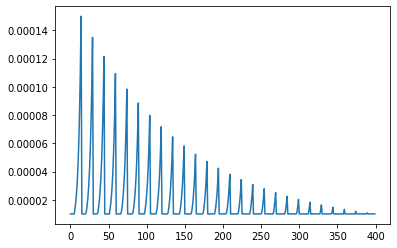

In [18]:
lr_schedule = CyclicalRateSchedule(min_lr = config_min_lr, max_lr = config_max_lr,
                                   n_epochs = config_epochs,
                                   warmup_epochs = config_warmup_epochs,
                                   cooldown_epochs = config_cooldown_epochs,
                                   cycle_length = config_cycle_length,
                                   logarithmic = True,
                                   decrease_factor = 0.9)

lr_schedule.plot_cycle()

##### Model Training

In [19]:
# Start timer and clear session
train_start_time = time.time()
keras.backend.clear_session()
    
# Checkpoint and early stopping
check_point = keras.callbacks.ModelCheckpoint(config_model_save_name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min',  patience = config_max_worse_epochs)
csv_name = "log_{ts}.csv".format(ts = config_model_timestamp)
csv_logger = keras.callbacks.CSVLogger(csv_name)

# Define model, scale to multiple GPUs, and start training
model = resnet_conv_70_layer()
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['categorical_accuracy'])

model.fit_generator(train_gen,
                    epochs = config_epochs,
                    validation_data = valid_gen,
                    validation_steps = vsteps,
                    steps_per_epoch = tsteps,
                    callbacks = [check_point, early_stop, lr_schedule.lr_scheduler(), csv_logger],
                    class_weight = dict(zip(list(range(len(class_weights))), class_weights)))

train_end_time = time.time()
sec_to_time_elapsed(train_end_time, train_start_time)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/400
1413/1414 [============================>.] - ETA: 0s - loss: 1.9904 - categorical_accuracy: 0.2963
Epoch 00001: val_loss improved from inf to 2.07054, saving model to cloud_scene_img_model_sgd_lrs_20191007_0313.hdf5
1414/1414 [==============================] - 547s 387ms/step - loss: 1.9904 - categorical_accuracy: 0.2963 - val_loss: 2.0705 - val_categorical_accuracy: 0.0312

Epoch 00002: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 2/400
1413/1414 [============================>.] - ETA: 0s - loss: 1.9355 - categorical_accuracy: 0.3256
Epoch 00002: val_loss did not improve from 2.07054
1414/1414 [==============================] - 487s 344ms/step - loss: 1.9356 - categorical_accuracy: 0.3255 - val_loss: 2.1790 - val_categorical_accuracy: 0.0524

Epoch 00003: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 3/400
1413/1414 [============================>.] - ETA: 0s - loss: 1.8990 -

1413/1414 [============================>.] - ETA: 0s - loss: 0.8694 - categorical_accuracy: 0.7824
Epoch 00020: val_loss did not improve from 0.85540
1414/1414 [==============================] - 486s 344ms/step - loss: 0.8693 - categorical_accuracy: 0.7825 - val_loss: 0.8872 - val_categorical_accuracy: 0.7431

Epoch 00021: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 21/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.8383 - categorical_accuracy: 0.7935
Epoch 00021: val_loss improved from 0.85540 to 0.80910, saving model to cloud_scene_img_model_sgd_lrs_20191007_0313.hdf5
1414/1414 [==============================] - 488s 345ms/step - loss: 0.8383 - categorical_accuracy: 0.7935 - val_loss: 0.8091 - val_categorical_accuracy: 0.7825

Epoch 00022: LearningRateScheduler reducing learning rate to 1.21596007644e-05.
Epoch 22/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.8153 - categorical_accuracy: 0.8028
Epoch 00022: val_loss improved fr


Epoch 00040: LearningRateScheduler reducing learning rate to 2.69893388018e-05.
Epoch 40/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.4976 - categorical_accuracy: 0.9071
Epoch 00040: val_loss improved from 0.69284 to 0.68667, saving model to cloud_scene_img_model_sgd_lrs_20191007_0313.hdf5
1414/1414 [==============================] - 489s 346ms/step - loss: 0.4974 - categorical_accuracy: 0.9072 - val_loss: 0.6867 - val_categorical_accuracy: 0.8379

Epoch 00041: LearningRateScheduler reducing learning rate to 3.64643983028e-05.
Epoch 41/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.5102 - categorical_accuracy: 0.9042
Epoch 00041: val_loss did not improve from 0.68667
1414/1414 [==============================] - 486s 344ms/step - loss: 0.5103 - categorical_accuracy: 0.9042 - val_loss: 0.7685 - val_categorical_accuracy: 0.8105

Epoch 00042: LearningRateScheduler reducing learning rate to 4.92658361641e-05.
Epoch 42/400
1413/1414 [===============


Epoch 00060: LearningRateScheduler reducing learning rate to 0.00010935.
Epoch 60/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.5680 - categorical_accuracy: 0.8842
Epoch 00060: val_loss did not improve from 0.62579
1414/1414 [==============================] - 487s 344ms/step - loss: 0.5680 - categorical_accuracy: 0.8842 - val_loss: 0.6465 - val_categorical_accuracy: 0.8573

Epoch 00061: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 61/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.4302 - categorical_accuracy: 0.9301
Epoch 00061: val_loss did not improve from 0.62579
1414/1414 [==============================] - 487s 344ms/step - loss: 0.4302 - categorical_accuracy: 0.9301 - val_loss: 0.6413 - val_categorical_accuracy: 0.8546

Epoch 00062: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 62/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.3886 - categorical_accuracy: 0.9456
Epoch 00062: val_loss improv

1413/1414 [============================>.] - ETA: 0s - loss: 0.3210 - categorical_accuracy: 0.9649
Epoch 00080: val_loss did not improve from 0.61249
1414/1414 [==============================] - 486s 344ms/step - loss: 0.3210 - categorical_accuracy: 0.9649 - val_loss: 0.6902 - val_categorical_accuracy: 0.8548

Epoch 00081: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 81/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.3146 - categorical_accuracy: 0.9658
Epoch 00081: val_loss did not improve from 0.61249
1414/1414 [==============================] - 487s 345ms/step - loss: 0.3146 - categorical_accuracy: 0.9658 - val_loss: 0.8443 - val_categorical_accuracy: 0.8173

Epoch 00082: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 82/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.3151 - categorical_accuracy: 0.9658
Epoch 00082: val_loss did not improve from 0.61249
1414/1414 [==============================] - 488s 345ms/step - l

1413/1414 [============================>.] - ETA: 0s - loss: 0.3020 - categorical_accuracy: 0.9693
Epoch 00100: val_loss did not improve from 0.52284
1414/1414 [==============================] - 486s 344ms/step - loss: 0.3020 - categorical_accuracy: 0.9693 - val_loss: 0.7166 - val_categorical_accuracy: 0.8585

Epoch 00101: LearningRateScheduler reducing learning rate to 2.39242917265e-05.
Epoch 101/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.3080 - categorical_accuracy: 0.9677
Epoch 00101: val_loss did not improve from 0.52284
1414/1414 [==============================] - 486s 344ms/step - loss: 0.3080 - categorical_accuracy: 0.9677 - val_loss: 0.7084 - val_categorical_accuracy: 0.8708

Epoch 00102: LearningRateScheduler reducing learning rate to 3.23233151073e-05.
Epoch 102/400
1413/1414 [============================>.] - ETA: 0s - loss: 0.3139 - categorical_accuracy: 0.9652
Epoch 00102: val_loss did not improve from 0.52284
1414/1414 [===========================

### Evaluation

#### Training Progress

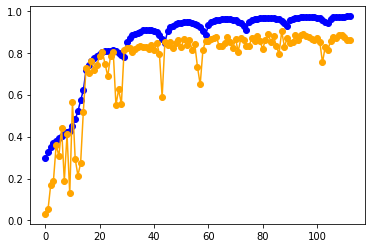

In [22]:
plot_training_progress(csv_file_path = "log_{ts}.csv".format(ts = config_model_timestamp),
                       train_metric = 'categorical_accuracy',
                       validation_metric = 'val_categorical_accuracy')

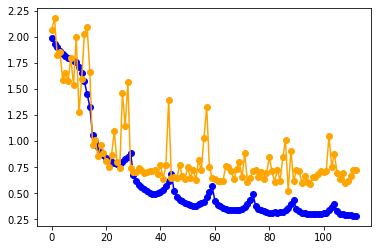

In [23]:
plot_training_progress(csv_file_path = "log_{ts}.csv".format(ts = config_model_timestamp),
                       train_metric = 'loss',
                       validation_metric = 'val_loss')

#### Test set accuracy metrics

In [24]:
cnn_model = keras.models.load_model(config_model_save_name)
probabilities = cnn_model.predict(test_x)

In [64]:
def unnest_lol(LOL):
    """unnest list of lists"""
    import itertools
    return list(itertools.chain.from_iterable(LOL))

error = unnest_lol([list(probabilities[i] - test_y[i]) for i in range(test_y.shape[0])])

In [104]:
true_pos = [int(probabilities[i,np.argmax(test_y[i])] >= 0.5) for i in range(test_y.shape[0])]
true_neg = unnest_lol([[int(y < 0.5) for i, y in enumerate(probabilities[r,:]) if i != np.argmax(test_y[r])] for r in range(test_y.shape[0])])
true_agg = true_pos + true_neg
tpr = sum(true_pos) / len(true_pos)
tnr = sum(true_neg) / len(true_neg)
acc = sum(true_agg) / len(true_agg)
pd.DataFrame({'acc' : [acc], 'tpr' : [tpr], 'tnr' : [tnr]})

acc     tnr       tpr
0  0.945767  0.9695  0.850833

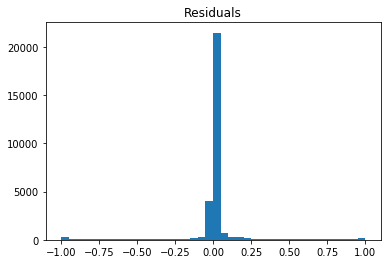

In [107]:
plt.hist(error, bins = 40)
plt.title("Residuals")
plt.show()

#### Look at random test set predictions

In [114]:
def temp_plot_test_obs(n = 40):
    for i in range(n):
        random_test_obs = random.choice(list(range(test_x.shape[0])))
        class_dict = {0 : "bathroom", 1 : "bedroom", 2 : "dining room", 3: "kitchen", 4 : "living room"}
        class_probs = [class_dict.get(i) + ":  " + str(round(x*100,5)) + "%" for i, x in enumerate(probabilities[random_test_obs])]
        actual = class_dict.get(np.argmax(test_y[random_test_obs]))
        plt.imshow(test_x[random_test_obs])
        plt.title("Actual: {a}".format(a = actual) + "\n" + "\n".join(class_probs))
        plt.show()

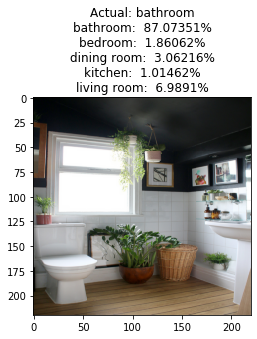

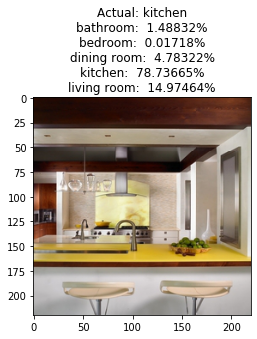

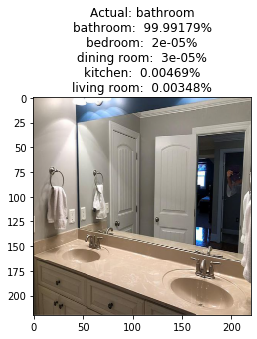

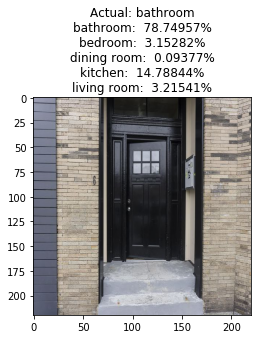

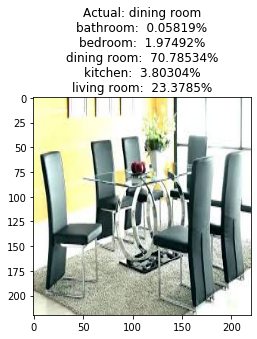

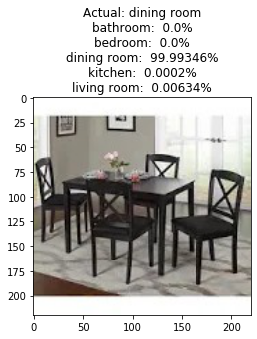

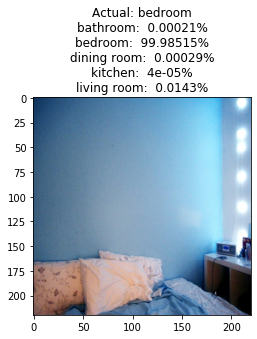

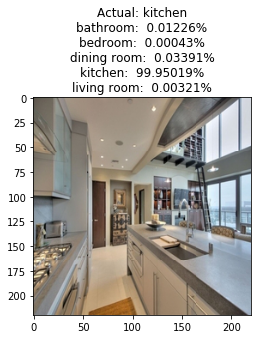

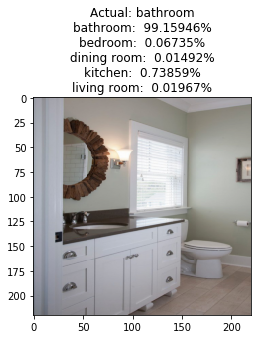

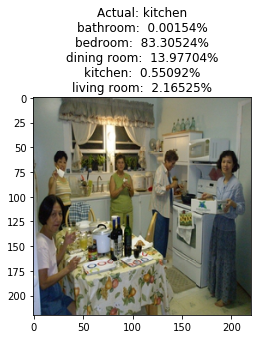

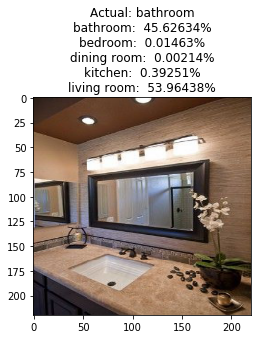

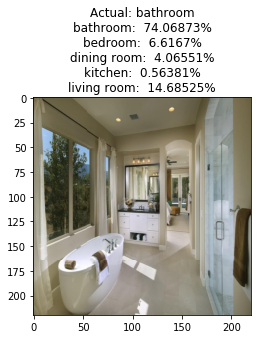

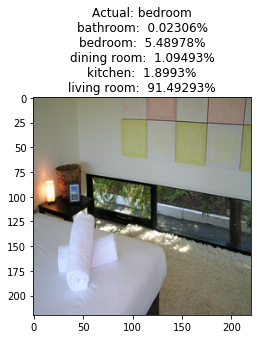

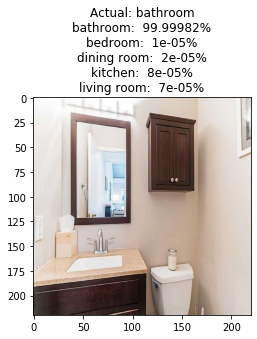

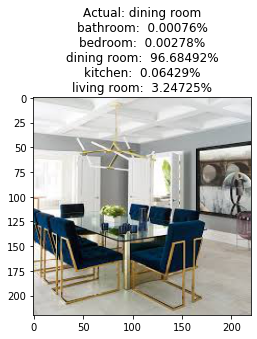

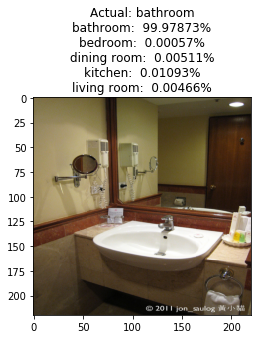

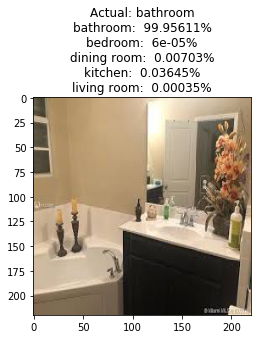

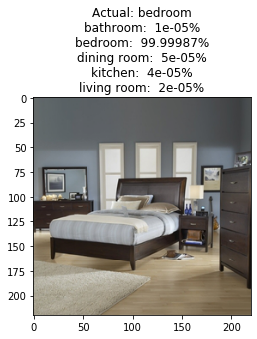

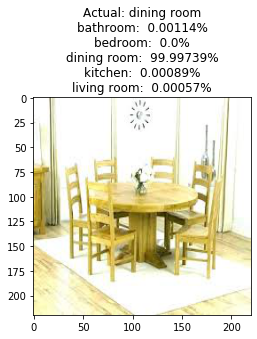

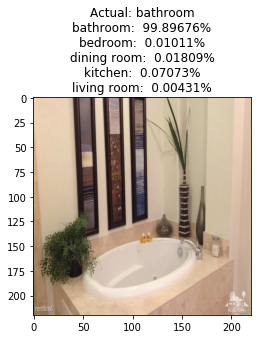

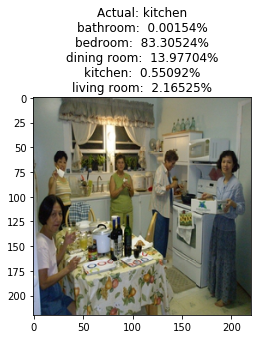

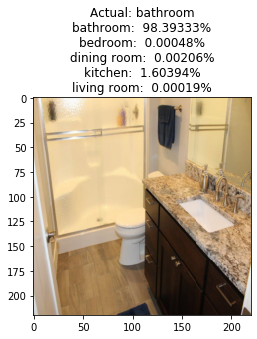

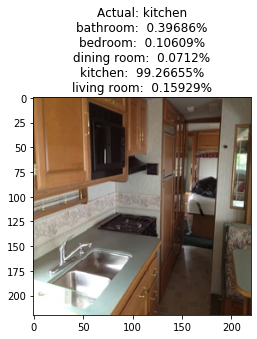

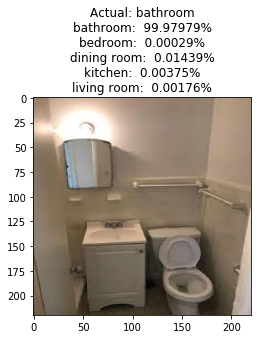

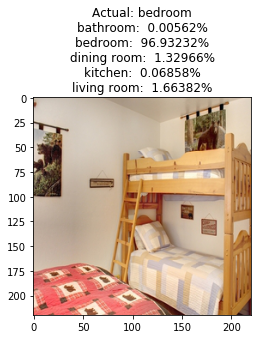

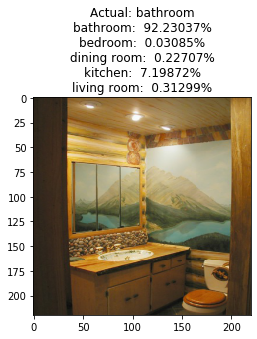

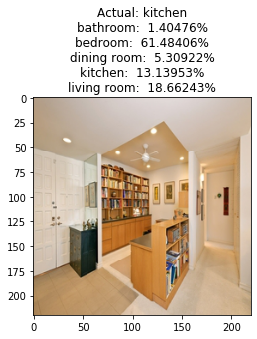

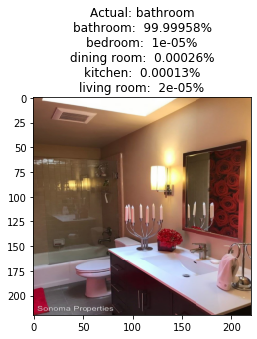

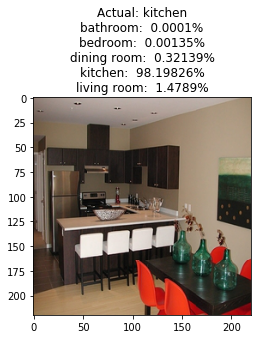

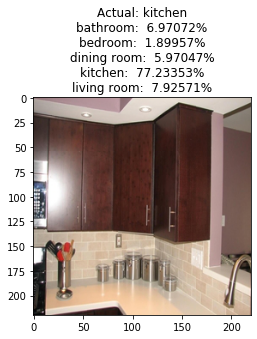

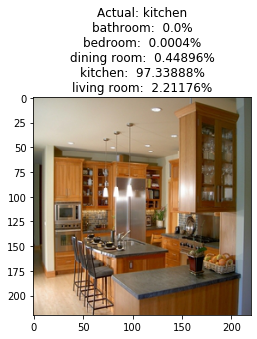

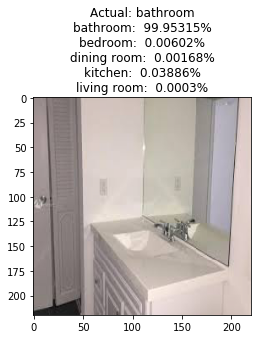

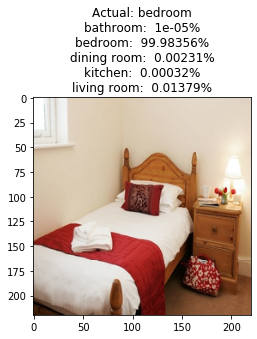

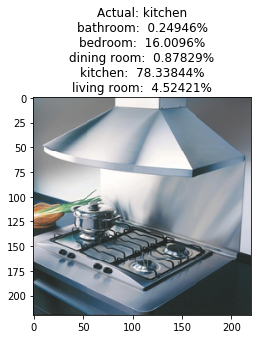

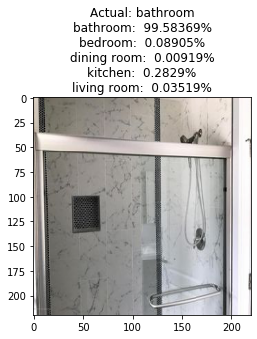

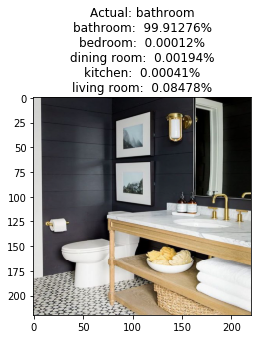

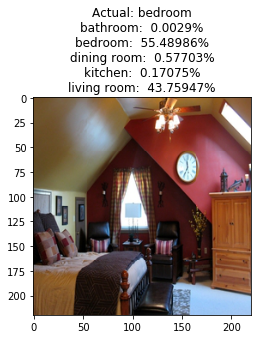

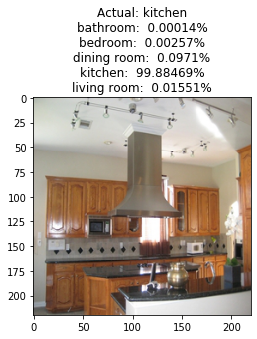

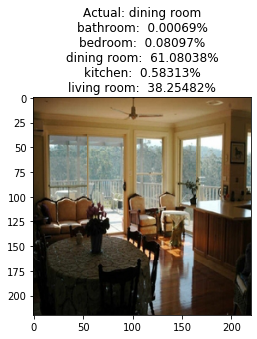

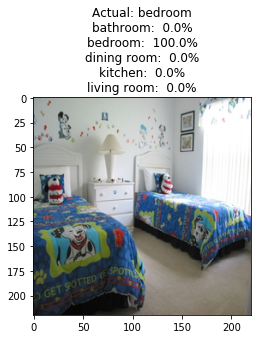

In [115]:
temp_plot_test_obs()

### Appendix